In [11]:
# !pip install sklearn-som
# !pip install python-louvain
# !pip install torch-cluster

# from torch_cluster import knn_graph
# import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.layers import Layer, Lambda, Dense, Input, LeakyReLU, BatchNormalization

from tensorflow.keras.utils import plot_model
# from tensorflow.keras.datasets import cifar10

from keras.datasets import mnist, cifar10
import tensorflow as tf

# tf.config.run_functions_eagerly(True)

from sklearn import metrics

import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
import networkx as nx

from sklearn.neighbors import kneighbors_graph
import community.community_louvain as community_louvain

from sklearn.cluster import KMeans, SpectralClustering
from scipy.optimize import linear_sum_assignment as linear_assignment

from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling

from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_blobs

In [4]:
def cluster_acc(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x:-x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc
  
def sampling(args):
    z_mean, z_log_sigma, latent_dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

def nmf_loss(input):
    S = kneighbors_graph(input, n_neighbors=5).toarray()

    nmf = NMF(n_components=10,
            init='random',
            random_state=0,
            max_iter=30
            )
    nmf.fit(S)
    return nmf.reconstruction_err_

def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

### Generate best S

In [5]:
def _get_nmf_S(X):
        
        nmf = NMF(
            n_components=20,
            init='random',
            random_state=0,
            max_iter=5000
        )

        S = kneighbors_graph(X, n_neighbors=5).toarray()

        # initial loss
        nmf.fit_transform(S)
        initial_loss = nmf.reconstruction_err_
        print('Initial loss: ', initial_loss)

        # Initialization
        T = 30
        best_loss = 999999999999999
        old_loss = 999999999999999
        best_S = S
        tol = 0.0001
        g_filter = 1.2

        for t in range(T):
            # a decomposição comprime os dados de entrada
            # logo as características mais relevantes (vizinhança forte)
            # tende a persistir nos dados comprimidos
            # e os detalhes menos relevantes da matriz de similaridade
            # tendem a desaparecer
            
            W = nmf.fit_transform(S)
            H = nmf.components_
            loss = nmf.reconstruction_err_

            # loss_rate.append(loss)
            if (loss > old_loss) or abs(old_loss - loss) <= tol:
                break

            if loss < best_loss:
                best_loss = loss
                best_S = kneighbors_graph(W.dot(H), n_neighbors=5).toarray()

            old_loss = loss
            
            S = gaussian_filter(W.dot(H), sigma=g_filter)

        print('best loss: ', best_loss)
        print('n iter: ', t)
        
        return best_S

# AE Model

In [14]:
def autoencoder_model(dims, act='relu'):
    
    # STEP 1: CREATE ENCODER
    n_stacks = len(dims) - 1
    # input
    input_visible = Input(shape=(dims[0],), name='data_input')
    x = input_visible
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation='relu', name='encoder_%d' % i)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # x = Conv1D(512, 2, activation="relu", padding="same")(x)
        # x = MaxPooling1D(4, padding="same")(x)

    # x = layers.AveragePooling1D()(x)
    # x = layers.Flatten()(x)

    latent_dim = dims[-1]

    #--- Custom Latent Space Layer
    z_mean = Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
    z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
    z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma, latent_dim]) # Z sampling layer

    # #--- Create Encoder model
    # encoder = Model(input_img, [z_mean, z_log_sigma, z], name='Encoder-Model')
    
    # hidden layer
    encoded = Dense(latent_dim, name='encoder_%d' % (n_stacks - 1))(z)  # hidden layer, features are extracted from here    

    # STEP 2: CREATE DECODER
    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation='relu', name='decoder_%d' % i)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        # x = Conv1D(dims[i], 32, activation="relu", padding="same")(x)
        # x = MaxPooling1D(4, padding="same")(x)

    # x = layers.AveragePooling1D()(x)
    # x = layers.Flatten()(x)

    # output
    decoded = Dense(dims[0], name='decoder_0')(x)
#     decoded = x

    # STEP 3: CREATE MODELS
#     decoder = Model(encoded, decoded, name='decoder')
    encoder = Model(inputs=input_visible, outputs=[z_mean, z_log_sigma, z], name='encoder')
    autoencoder = Model(inputs=input_visible, outputs=decoded, name='AE')

    # STEP 4: CREATE CUSTOM LOSS
    z_mean, z_log_sigma, z = encoder(input_visible)

#     output = decoder(z)
    output = autoencoder(input_visible)

    # Reconstruction loss compares inputs and outputs and tries to minimise the difference
    r_loss = keras.losses.mean_squared_error(input_visible, output)  # use MSE
    r_loss *= dims[0] 

    # KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
    kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

    # The VAE loss is a combination of reconstruction loss and KL loss
    vae_loss = K.mean(r_loss + kl_loss) #+ nmf_reconstruction_loss)

    # Add loss to the model and compile it
    autoencoder.add_loss(vae_loss)

    return autoencoder, encoder#, decoder 

# Real Data

n_clusters:  10
shape:  (130, 2400)


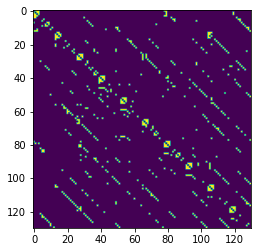

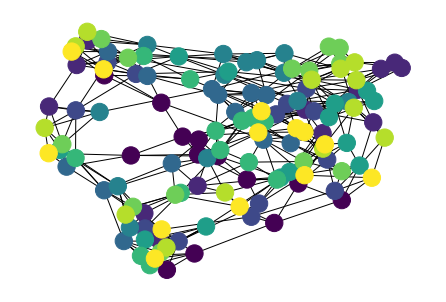

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/marcosd3souza/FSMethodology/master/train_datasets/warpAR10P_dataset.csv', sep=' ')

X = data.drop(['Y'], axis=1)
y = data['Y']

k = len(np.unique(y))

print('n_clusters: ', k)
print('shape: ', X.shape)

S = kneighbors_graph(X, n_neighbors=5)
plt.imshow(S.toarray())
plt.show()

G = nx.from_scipy_sparse_matrix(S)
nx.draw(G, node_color=y)

In [17]:
import sys
sys.setrecursionlimit(30000)

Initial loss:  17.110871794874136
best loss:  0.013235308613012644
n iter:  2


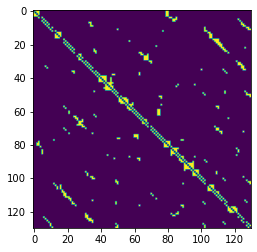

In [9]:
S_new = _get_nmf_S(X)
plt.imshow(S_new)

### Train models

In [ ]:
dims = [X.shape[0], 100, 50, 10]
# init = VarianceScaling(scale=1. / 3., mode='fan_in',
#                            distribution='uniform')
# pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = 30
batch_size = 32

autoencoder, encoder, decoder = autoencoder_model(dims)

# S = np.sort(S.toarray(), axis=0)

autoencoder.compile(optimizer='adam')
autoencoder.fit(S_new, S_new, batch_size=batch_size, epochs=pretrain_epochs)

5/5 [==============================] - 0s 10ms/step


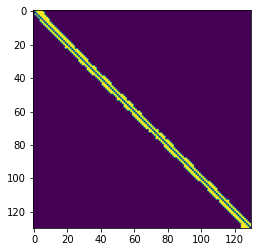

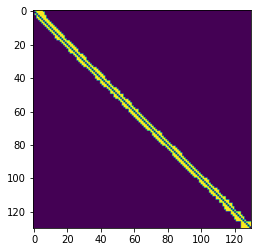

In [ ]:
D = pairwise_distances(X)
D = np.sort(D, axis=0)
S = kneighbors_graph(D, n_neighbors=5).toarray()
X_encoded = autoencoder.predict(S)

plt.imshow(S)
plt.show()


D = pairwise_distances(X_encoded)
D = np.sort(D, axis=0)
S = kneighbors_graph(D, n_neighbors=5).toarray()
_ = plt.imshow(S)

### Performance sem reduzir

10
acc:  0.8
nmi: 0.8084713638597751
cr:  0.6448582995951417


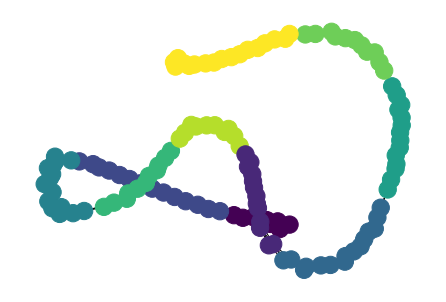

In [ ]:
# louvain 
# A = kneighbors_graph(X_encoded, 5, mode='connectivity')
D = pairwise_distances(X)
D = np.sort(D, axis=0)
S = kneighbors_graph(D, n_neighbors=5)
# S = kneighbors_graph(X_encoded, n_neighbors=5)

G = nx.from_scipy_sparse_matrix(S)
partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)

y_louvain = np.array([i for i in partition.values()])
print(len(np.unique(y_louvain)))

acc = cluster_acc(y_test, y_louvain)
nmi = metrics.normalized_mutual_info_score(y_test, y_louvain)
cr = metrics.adjusted_rand_score(y_test, y_louvain)

print('acc: ', acc)
print('nmi:', nmi)
print('cr: ', cr)

nx.draw(G, node_color=y_louvain)

In [ ]:
# spectral

P = pairwise_distances(X, metric='euclidean')
P = np.sort(P, axis=0)
# S = kneighbors_graph(X_encoded, n_neighbors=9)
spectral = SpectralClustering(n_clusters=k_clusters, n_neighbors=5, affinity='precomputed_nearest_neighbors', random_state=0).fit(P)

y_spectral = spectral.labels_

acc = cluster_acc(y_test, y_spectral)
nmi = metrics.normalized_mutual_info_score(y_test, y_spectral)
cr = metrics.adjusted_rand_score(y_test, y_spectral)

print(acc)
print(nmi)
print(cr)

0.46923076923076923
0.521829126768131
0.24222776392352452


### Performance usando o espaço latente

n classes:  10
n clusters:  9
acc:  0.6846153846153846
nmi: 0.7551403832021729
cr:  0.5399176954732511


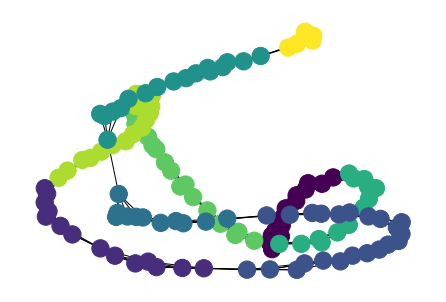

In [ ]:
# louvain 
# A = kneighbors_graph(X_encoded, 5, mode='connectivity')
# S = kneighbors_graph(X_sorted, n_neighbors=5)
# D = pairwise_distances(X_encoded)
# D = np.sort(D, axis=0)
# S = kneighbors_graph(X_encoded, n_neighbors=5)
D = pairwise_distances(X_encoded)
D = np.sort(D, axis=0)
S = kneighbors_graph(D, n_neighbors=5)

G = nx.from_scipy_sparse_matrix(S)
partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)

y_louvain = np.array([i for i in partition.values()])
print('n classes: ', len(np.unique(y_test)))
print('n clusters: ', len(np.unique(y_louvain)))

acc = cluster_acc(y_test, y_louvain)
nmi = metrics.normalized_mutual_info_score(y_test, y_louvain)
cr = metrics.adjusted_rand_score(y_test, y_louvain)

print('acc: ', acc)
print('nmi:', nmi)
print('cr: ', cr)

nx.draw(G, node_color=y_louvain)
# plt.show()
# nx.draw(G, node_color=y_test)

In [ ]:
# spectral

# P = pairwise_distances(X_encoded)
# P = np.sort(, axis=0)
D = pairwise_distances(X_encoded)
D = np.sort(P, axis=0)
S = kneighbors_graph(D, n_neighbors=5).toarray()
spectral = SpectralClustering(n_clusters=k_clusters, affinity='precomputed_nearest_neighbors', random_state=0).fit(S)

y_spectral = spectral.labels_

acc = cluster_acc(y_test, y_spectral)
nmi = metrics.normalized_mutual_info_score(y_test, y_spectral)
cr = metrics.adjusted_rand_score(y_test, y_spectral)

print(acc)
print(nmi)
print(cr)

0.3384615384615385
0.5017618011227509
0.1892601431980907
